## 3D plot of Assistant Axis

In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd

sys.path.append('.')
sys.path.append('..')

from utils.pca_utils import L2MeanScaler, MeanScaler, compute_pca, plot_variance_explained

import matplotlib.pyplot as plt
plt.style.use('./arena.mplstyle')

In [2]:
plot_output_dir = "/root/git/plots/paper"
model_short = "llama-3.3-70b"
layer = 40
dir = f"/workspace/{model_short}"


In [3]:
pca_results = torch.load(f"{dir}/roles_240/pca/layer{layer}_mean_pos23.pt", weights_only=False)
default_vectors = torch.load(f"{dir}/roles_240/default_vectors.pt")

In [4]:
# also calculate role labels for plotting
def get_role_labels(pca_results):
    labels = []
    if 'pos_2' in pca_results['roles'].keys():
        pos_2_roles = [role.replace('_', ' ').title() for role in pca_results['roles']['pos_2']]
        pos_2_roles = [f"{role} (Somewhat RP)" for role in pos_2_roles]
        labels.extend(pos_2_roles)
    if 'pos_3' in pca_results['roles'].keys():
        pos_3_roles = [role.replace('_', ' ').title() for role in pca_results['roles']['pos_3']]
        pos_3_roles = [f"{role} (Fully RP)" for role in pos_3_roles]
        labels.extend(pos_3_roles)
    return labels

role_labels = get_role_labels(pca_results)
print(len(role_labels))

377


In [5]:
assistant_layer_activation = default_vectors['activations']['default_1'][layer].float().reshape(1, -1)

asst_scaled = pca_results['scaler'].transform(assistant_layer_activation)
asst_projected = pca_results['pca'].transform(asst_scaled)

assistant_layer_activation = assistant_layer_activation.numpy()

In [6]:
import torch.nn.functional as F

contrast_vector = torch.load(f"{dir}/roles_240/contrast_vectors.pt", weights_only=False)[layer]
# normalize contrast vector
contrast_vector = F.normalize(contrast_vector, dim=0).float()
# replace first PC with contrast vector
# pca_results['pca'].components_[0] = contrast_vector.float()

In [7]:
role_vectors = pca_results['vectors']['pos_2'] + pca_results['vectors']['pos_3']

In [10]:
# Get the 3 PC directions (PC1 = contrast vector, PC2, PC3)
pca_results['pca'].components_[0] = pca_results['pca'].components_[0] * -1
pca_results['pca'].components_[1] = pca_results['pca'].components_[1] * -1
# pca_results['pca'].components_[2] = pca_results['pca'].components_[2] * -1

pc_directions = torch.tensor(pca_results['pca'].components_[:3]).float()
pc_directions = F.normalize(pc_directions, dim=1)

# Stack role vectors at the specific layer
role_vectors_at_layer = torch.stack([v[layer] for v in role_vectors]).float()

# Scale role vectors and assistant activation (to match PCA space)
role_vectors_scaled = torch.tensor(pca_results['scaler'].transform(role_vectors_at_layer)).float()
assistant_scaled = torch.tensor(pca_results['scaler'].transform(torch.tensor(assistant_layer_activation))).float()

# Normalize for cosine similarity
role_vectors_norm = F.normalize(role_vectors_scaled, dim=1)
assistant_norm = F.normalize(assistant_scaled, dim=1)

# Compute cosine similarities with PC directions: (n_roles, 3)
role_cosine_sims = role_vectors_norm @ pc_directions.T
assistant_cosine_sims = assistant_norm @ pc_directions.T

# Compute cosine similarities with contrast vector (for gradient coloring)
role_contrast_cosine_sims = (role_vectors_norm @ contrast_vector).numpy()

# Determine which roles to label
role_cos = role_cosine_sims.numpy()
n_roles = len(role_vectors)

# Roles to always/never label
# always_label: pos_3 only. Available: print(pca_results['roles']['pos_3'])
# never_label: pos_2 or pos_3. Available: print(pca_results['roles']['pos_2']), print(pca_results['roles']['pos_3'])
always_label = [
    'generalist', 'egregore', 'demon'
]
never_label = [
    'assistant', 'pacifist','veteran','coach', 'prey', 'destroyer', 'amateur','negotiator', 'networker', 'toddler','traditionalist', 'activist','philosopher', 'mentor','instructor', 'skeptic','teenager','spy','leviathan','shaman','negotiator','networker','toddler','traditionalist', 'activist','philosopher', 'instructor', 'skeptic','teenager','spy','leviathan','negotiator','swarm'
]

# Convert to indices
pos_2_roles = pca_results['roles']['pos_2']
pos_3_roles = pca_results['roles']['pos_3']
n_pos_2 = len(pos_2_roles)

# always_label: pos_3 only
always_label_idx = set(n_pos_2 + pos_3_roles.index(r) for r in always_label if r in pos_3_roles)

# never_label: searches both pos_2 and pos_3
def get_role_indices(role_name):
    """Get ALL indices for a role name (can appear in both pos_2 and pos_3)."""
    indices = []
    if role_name in pos_2_roles:
        indices.append(pos_2_roles.index(role_name))
    if role_name in pos_3_roles:
        indices.append(n_pos_2 + pos_3_roles.index(role_name))
    return indices

never_label_idx = set(idx for r in never_label for idx in get_role_indices(r))

# Find extreme indices for each PC (10 lowest + 10 highest)
extreme_indices = set()
for pc_idx in range(3):
    col = role_cos[:, pc_idx].flatten()
    sorted_idx = np.argsort(col)
    extreme_indices.update(sorted_idx[:12:3].astype(int).tolist())   # lowest 10
    extreme_indices.update(sorted_idx[-12::3].astype(int).tolist())  # highest 10

# Sample 1/10 of remaining roles
remaining_indices = [i for i in range(n_roles) if i not in extreme_indices]
np.random.seed(42)
sample_size = max(1, len(remaining_indices) // 20)
sampled_indices = set(np.random.choice(remaining_indices, size=sample_size, replace=False).tolist())

# Combine indices to label
indices_to_label = (extreme_indices | sampled_indices | always_label_idx) - never_label_idx

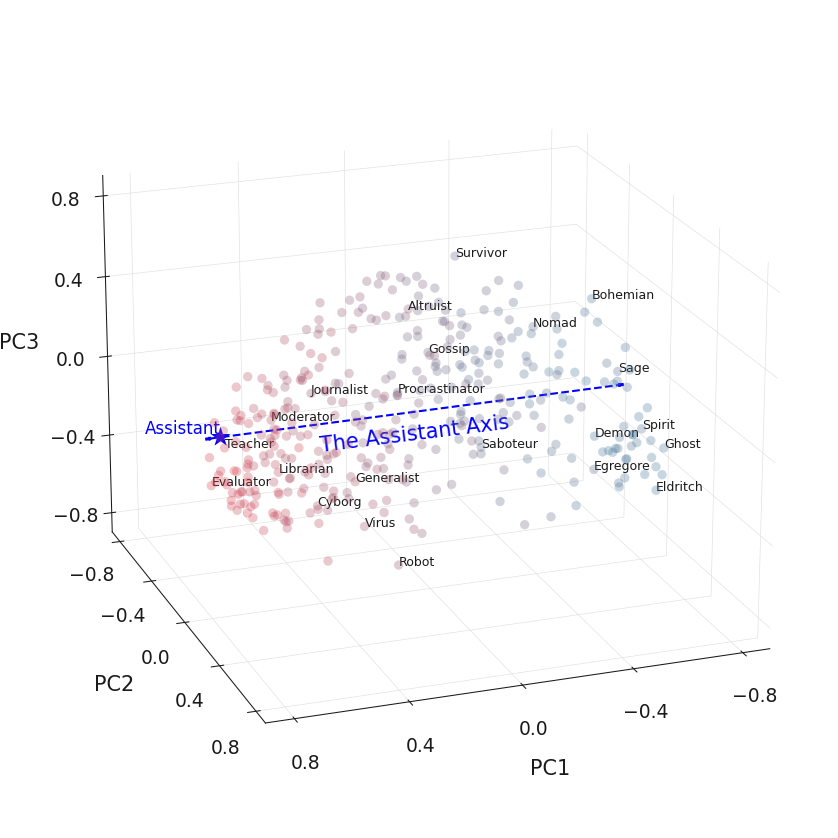

In [11]:
# Create 3D scatter plot with contrast vector as x-axis
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')

# Axes: x=PC1, y=PC2, z=PC3
x = role_cos[:, 0]  # PC1
y = role_cos[:, 1]  # PC2
z = role_cos[:, 2]  # PC3

# Custom colormap from red to blue
from matplotlib.colors import LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list('rp_asst', ['#e63946', '#457b9d'])

# Color by cosine similarity with contrast vector
contrast_norm = (role_contrast_cosine_sims - role_contrast_cosine_sims.min()) / (role_contrast_cosine_sims.max() - role_contrast_cosine_sims.min())
colors = custom_cmap(contrast_norm)

# Plot role vectors
sc = ax.scatter(x, y, z, c=colors, alpha=0.3, label='Roles')

# Add labels for selected roles
for i in indices_to_label:
    short_label = role_labels[i].split(' (')[0]
    ax.text(role_cos[i, 0], role_cos[i, 1], role_cos[i, 2],
            short_label, fontsize=6)

# Plot assistant
asst_cos = assistant_cosine_sims.numpy()[0]

# Get contrast vector direction in PC space (this is the Assistant Axis)
contrast_in_pc_space = (pc_directions @ contrast_vector).numpy()  # shape (3,)
contrast_dir = contrast_in_pc_space / np.linalg.norm(contrast_in_pc_space)  # normalize

# Calculate t values to reach x.min() and x.max()
t_min = (x.min() - asst_cos[0]) / contrast_dir[0]
t_max = (x.max() - asst_cos[0]) / contrast_dir[0]

# Draw dashed line along contrast vector direction from x.min() to x.max()
t = np.linspace(t_min, t_max, 100)
axis_line_x = asst_cos[0] + t * contrast_dir[0]
axis_line_y = asst_cos[1] + t * contrast_dir[1]
axis_line_z = asst_cos[2] + t * contrast_dir[2]
ax.plot(axis_line_x, axis_line_y, axis_line_z, '--', linewidth=1, label='Assistant Axis', c='blue')

# Add arrows at both ends of the assistant axis
arrow_scale = 0.02
# Arrow at negative end
ax.quiver(axis_line_x[0], axis_line_y[0], axis_line_z[0], 
          -contrast_dir[0]*arrow_scale, -contrast_dir[1]*arrow_scale, -contrast_dir[2]*arrow_scale,
          color='blue', arrow_length_ratio=0.5)
# Arrow at positive end
ax.quiver(axis_line_x[-1], axis_line_y[-1], axis_line_z[-1], 
          contrast_dir[0]*arrow_scale, contrast_dir[1]*arrow_scale, contrast_dir[2]*arrow_scale,
          color='blue', arrow_length_ratio=0.5)

# Text for assistant axis - at midpoint of the line, using zdir='x' for orientation
mid_idx = len(axis_line_x) // 2
ax.text(axis_line_x[mid_idx], axis_line_y[mid_idx], axis_line_z[mid_idx], 
        'The Assistant Axis', zdir='x', fontsize=10, color='blue', ha='center', va='top')

ax.scatter([asst_cos[0]], [asst_cos[1]], [asst_cos[2]],
           c='blue', marker='*', s=100, label='Assistant', edgecolors='none')
# Assistant label anchored by bottom right
ax.text(asst_cos[0], asst_cos[1], asst_cos[2], 'Assistant', fontsize=8, color='blue', ha='right', va='bottom')

# Labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Remove grid
ax.grid(True)

# Remove the gray panes (background planes)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Remove pane edges
ax.xaxis.pane.set_edgecolor('none')
ax.yaxis.pane.set_edgecolor('none')
ax.zaxis.pane.set_edgecolor('none')

ax.set_xticks([-0.8, -0.4, 0, 0.4, 0.8])
ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
ax.set_zticks([-0.8, -0.4, 0, 0.4, 0.8])

ax.set_xlim(-0.9, 0.9)
ax.set_ylim(-0.9, 0.9)
ax.set_zlim(-0.9, 0.9)

ax.view_init(elev=20, azim=70) 

plt.show()

In [27]:
from matplotlib.colors import LinearSegmentedColormap

def plot_pc_line(role_cosine_sims, pc_idx, role_labels, pca_results,
                 include_labels=None, exclude_labels=None,
                 assistant_cosine_sim=None, contrast_cosine_sims=None,
                 title=None, figsize=(8, 3),
                 n_extremes=5, show_histogram=True):
    """
    Plot a single PC's cosine similarities on a line.

    Args:
        role_cosine_sims: (n_roles, 3) array of cosine similarities
        pc_idx: Which PC to plot (0, 1, or 2)
        role_labels: Full list of role labels with "(Somewhat RP)"/"(Fully RP)" suffixes
        pca_results: Dict with 'roles' containing 'pos_2' and 'pos_3' lists
        include_labels: List of pos_3 role names to label (besides ends)
        exclude_labels: List of role names to exclude from labeling
        assistant_cosine_sim: Optional (3,) array of assistant cosine sims
        contrast_cosine_sims: Optional (n_roles,) array of cosine sims with contrast vector for coloring
        title: Optional title string
        figsize: Figure size tuple
        n_extremes: Number of extremes to label on each end
        show_histogram: Whether to show histogram overlay
    """
    include_labels = include_labels or []
    exclude_labels = exclude_labels or []
    
    # Get projections for this PC
    projections = role_cosine_sims[:, pc_idx]
    
    # Build role name lookup (maps raw name -> index)
    pos_2_roles = pca_results['roles']['pos_2']
    pos_3_roles = pca_results['roles']['pos_3']
    n_pos_2 = len(pos_2_roles)
    
    def get_role_indices(role_name):
        """Get ALL indices for a role name (can appear in both pos_2 and pos_3)."""
        indices = []
        if role_name in pos_2_roles:
            indices.append(pos_2_roles.index(role_name))
        if role_name in pos_3_roles:
            indices.append(n_pos_2 + pos_3_roles.index(role_name))
        return indices
    
    # Build exclude set (check both pos_2 and pos_3)
    exclude_idx = set()
    for r in exclude_labels:
        exclude_idx.update(get_role_indices(r))
    
    # Build include set (from pos_3 only as specified)
    include_idx = set()
    for r in include_labels:
        if r in pos_3_roles:
            include_idx.add(n_pos_2 + pos_3_roles.index(r))
    
    # Find extreme indices from full list first, then exclude
    sorted_indices = np.argsort(projections)
    low_extreme_indices = list(sorted_indices[:n_extremes*3:3])  # every 3rd from low end
    high_extreme_indices = list(sorted_indices[::-1][:n_extremes*3:3])  # every 3rd from high end
    extreme_indices = set(low_extreme_indices + high_extreme_indices)
    
    # Indices to label = extremes + include, minus exclude
    indices_to_label = (extreme_indices | include_idx) - exclude_idx
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Create gradient colormap
    custom_cmap = LinearSegmentedColormap.from_list('RedBlue1', ['#e63946', '#457b9d'])
    
    # Determine colors based on contrast cosine sims
    if contrast_cosine_sims is not None:
        c_norm = (contrast_cosine_sims - contrast_cosine_sims.min()) / (contrast_cosine_sims.max() - contrast_cosine_sims.min())
        colors = custom_cmap(c_norm)
    else:
        colors = '#457b9d'
    
    # Plot all points with gradient colors
    y_pos = np.zeros_like(projections)
    ax.scatter(projections, y_pos, c=colors, marker='o', s=40, 
               alpha=0.6, edgecolors='none', zorder=3)
    
    # Add histogram overlay
    if show_histogram:
        hist_counts, bin_edges = np.histogram(projections, bins=30, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bin_width = bin_edges[1] - bin_edges[0]
        
        hist_scale = 0.4
        scaled_heights = hist_counts * hist_scale
        
        # Color histogram bars with gradient if contrast_cosine_sims provided
        if contrast_cosine_sims is not None:
            bin_norm = (bin_centers - contrast_cosine_sims.min()) / (contrast_cosine_sims.max() - contrast_cosine_sims.min())
            bin_norm = np.clip(bin_norm, 0, 1)  # Clip to valid range
            bin_colors = custom_cmap(bin_norm)
            ax.bar(bin_centers, scaled_heights, width=bin_width, 
                   alpha=0.3, color=bin_colors, edgecolor='none', zorder=1)
        else:
            ax.bar(bin_centers, scaled_heights, width=bin_width, 
                   alpha=0.3, color='#457b9d', edgecolor='none', zorder=1)
    
    # Add Assistant if provided
    if assistant_cosine_sim is not None:
        asst_val = assistant_cosine_sim[pc_idx]
        ax.axvline(x=asst_val, color='blue', linestyle='--', linewidth=1, alpha=0.9, zorder=2)
        ax.scatter([asst_val], [0], c='blue', marker='*', s=300, alpha=1.0,
                linewidth=2, zorder=5)
        ax.text(asst_val, 0.6, 'Assistant', ha='center', va='bottom', fontsize=12,
                color='blue', alpha=0.9)
    
    # Fixed label heights - alternate above/below
    label_height_above = 0.2
    label_height_below = -0.2
    
    # Sort indices to label by projection value for consistent positioning
    sorted_label_indices = sorted(indices_to_label, key=lambda i: projections[i])
    
    for i, idx in enumerate(sorted_label_indices):
        label = role_labels[idx].split(' (')[0]  # Remove "(Somewhat RP)" etc
        x_pos = projections[idx]
        y_label = label_height_above if idx % 2 == 0 else label_height_below
        
        # Draw leader line
        ax.plot([x_pos, x_pos], [0.0, y_label], '--',color='black', alpha=0.7, linewidth=1, zorder=1)
        
        # Add text label at 45 degrees
        if y_label > 0:
            ax.text(x_pos, y_label, label, ha='left', va='bottom', fontsize=10, zorder=4,
                    rotation=45, rotation_mode='anchor')
        else:
            ax.text(x_pos, y_label, label, ha='right', va='top', fontsize=10, zorder=4,
                    rotation=45, rotation_mode='anchor')
    
    # Style
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=2, zorder=1)
    
    ax.tick_params(axis='x', length=12, width=1.5, pad=10)
    ax.tick_params(axis='y', length=0, width=0)
    ax.set_yticks([])
    ax.set_xticks([-0.8, -0.4, 0, 0.4, 0.8])
    ax.set_ylim(-0.6, 0.6)
    
    max_abs = max(abs(projections.min()), abs(projections.max()))
    ax.set_xlim(-1, 1)
    
    ax.grid(False)
    ax.set_xlabel(f'PC{pc_idx + 1}', fontsize=14, loc='left')
    
    if title:
        ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig

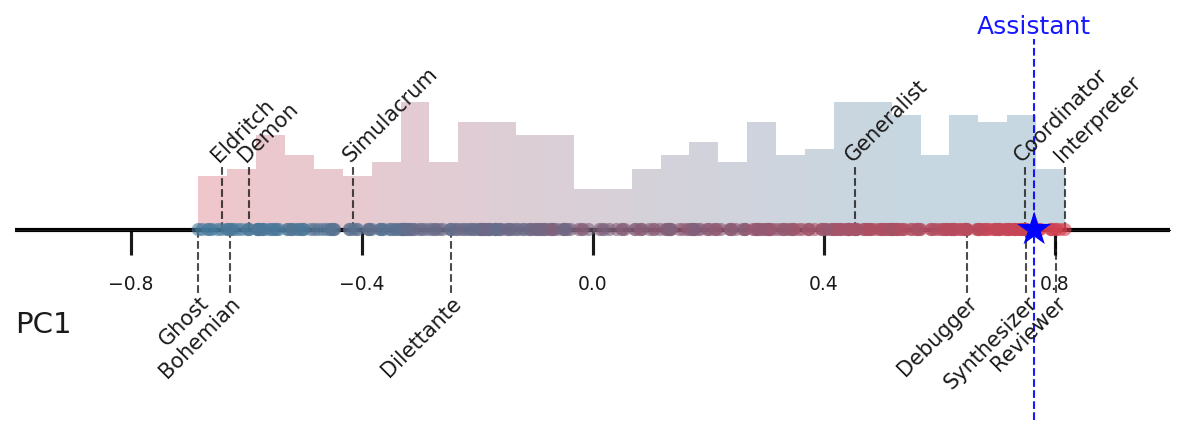

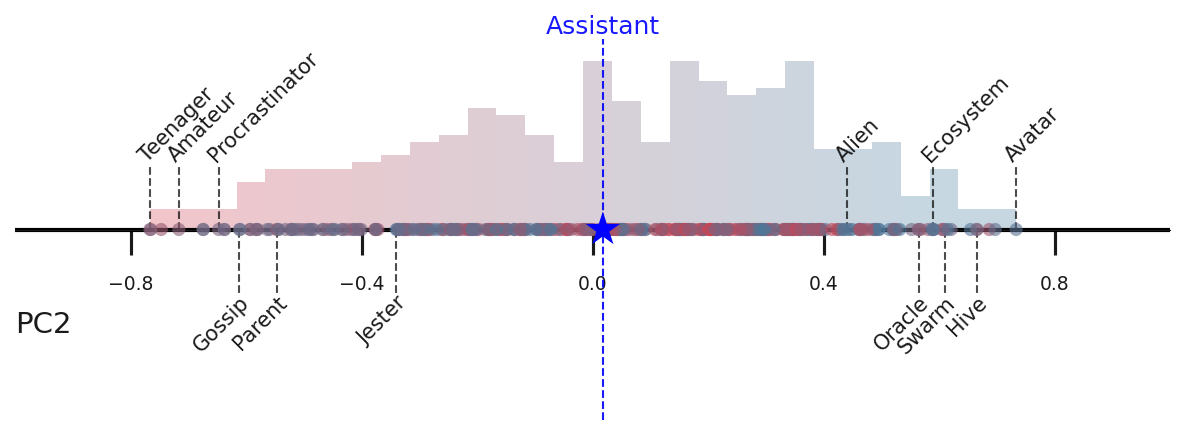

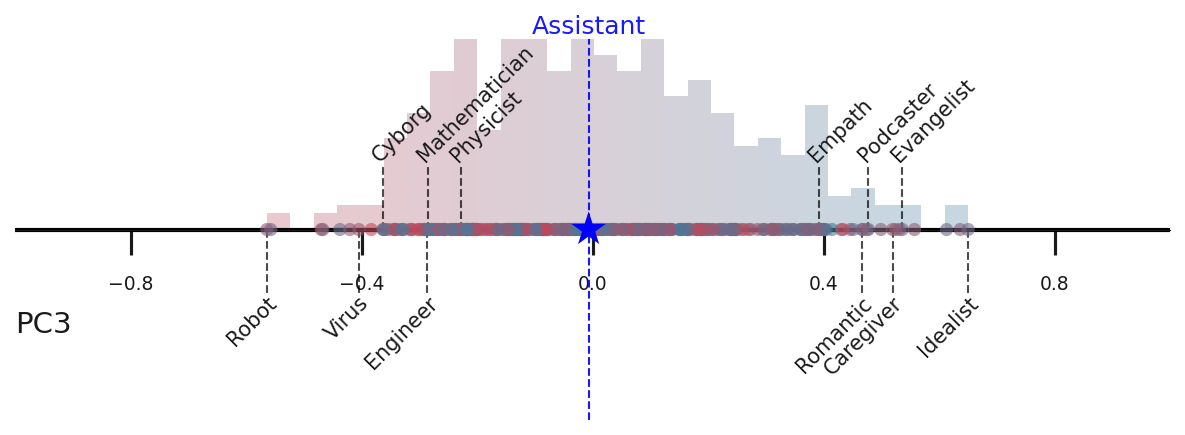

In [28]:
# Configure labels per PC - adjust these lists as needed
# include_labels: roles from pos_3 to label between the extremes
# exclude_labels: roles from pos_2 or pos_3 to never label

pc_config = {
    0: {  # PC1
        'include_labels': ['generalist', 'debugger', 'dilettante', 'simulacrum', 'demon'],  # e.g. ['egregore', 'angel']
        'exclude_labels': ['assistant', 'leviathan', 'aberration', 'collaborator'],
    },
    1: {  # PC2
        'include_labels': ['swarm', 'oracle', 'alien', 'parent', 'jester'],
        'exclude_labels': ['prisoner', 'polymath', 'zeitgeist'],
    },
    2: {  # PC3
        'include_labels': ['engineer', 'mathematician', 'physicist', 'evangelist', 'caregiver', 'empath'],
        'exclude_labels': ['navigator', 'blogger', 'toddler', 'optimist'],
    },
}

# Generate plots for PC1, PC2, PC3
asst_cos = assistant_cosine_sims.numpy()[0]

for pc_idx in range(3):
    fig = plot_pc_line(
        role_cos, pc_idx, role_labels, pca_results,
        include_labels=pc_config[pc_idx]['include_labels'],
        exclude_labels=pc_config[pc_idx]['exclude_labels'],
        assistant_cosine_sim=asst_cos,
        contrast_cosine_sims=role_contrast_cosine_sims,
        n_extremes=5,
        show_histogram=True
    )
    plt.savefig(f"{plot_output_dir}/pc{pc_idx+1}_line.pdf", dpi=300, bbox_inches='tight')
    plt.show()